In [1]:
import os; os.chdir('../')

import gc
import copy
import json
import pickle
import itertools

import numpy as np
import pandas as pd
import networkx as nx

import scipy.stats as statsc
from pingouin import partial_corr
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

import warnings; warnings.filterwarnings("ignore")

from causal_inference.scm_model import StructuralEquationModeler
from utils import Config, Data_Manager, model_selection
from analysis.utils_figs import (
    parse_preds, 
    bayes_factor_spearman, 
    set_style, 
    df2obs, 
    get_trend,
    bootstrap_outcomes, get_nx_graphs, graph_stats, draw_graph,
)

diverging_cmap, c_darkorange_rgb, c_orange_rgb, c_blue_rgb, c_white_rgb, c_navy_rgb, c_gray_rgb, c_lightgray_rgb = set_style()
pd.set_option('future.no_silent_downcasting', True)

In [2]:
cfg = Config()
dm = Data_Manager(cfg)
symp_label_dict, sub_dim_dict, symp_keys, subdim_keys = dm.load_dict(dict_type='label') 
dim_qkey_dict = dm.load_dict(dict_type='dim-query-key')

abbv_dict = dm.load_dict(dict_type='abbv')
symp_keys = list(abbv_dict.values())
symp_label_dict = {abbv_dict[k]: v for k, v in symp_label_dict.items()}

label_dict = symp_label_dict

depress_keys = symp_keys[:6]
manic_keys = symp_keys[6:]

Processing model: Qwen/Qwen3-32B


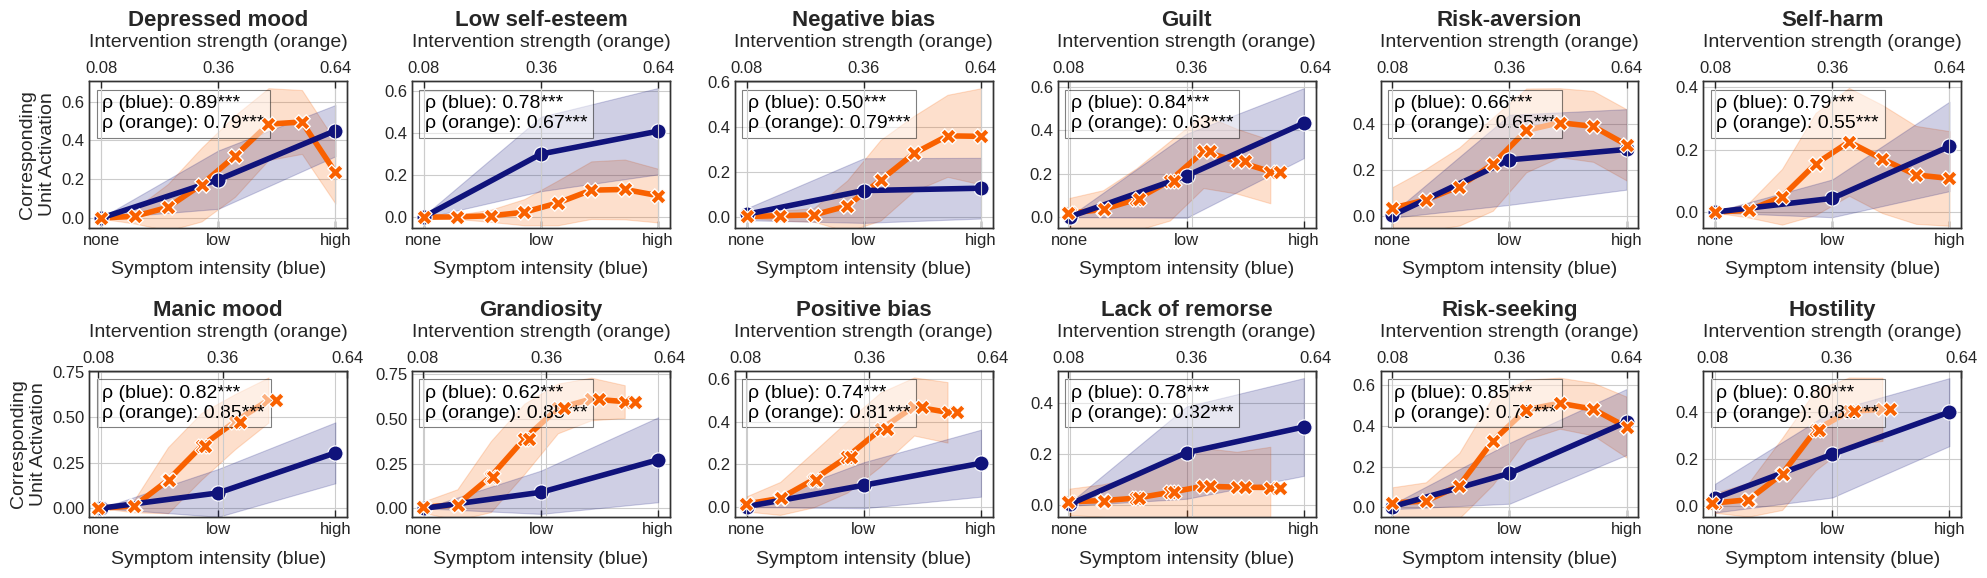

In [ ]:
### Run this code only after obtaining:
### 1) Intervention evaluations (itv_eval) - QNA/run_exp.ipynb 
### 2) Severity correlation evaluations (act_corr_eval) - analysis/s3ae.ipynb

# --- 1. Load & Config ---
llm = "Qwen/Qwen3-32B"
save_result = False

print(f"Processing model: {llm}")
cfg = Config(model_id=llm)
dm = Data_Manager(cfg)

# Helper to parse JSON string columns to DataFrame

# --- 2. Process Intervention Data ---
df_itv = dm.load_output(data_type='itv_eval')
df_itv = df_itv[~df_itv['output_text'].str.contains('Response unavailable.')]
df_itv = df_itv[df_itv['query'].isin(symp_keys + subdim_keys)].reset_index(drop=True)

# Calculate strengths and thoughts
thoughts = pd.get_dummies(df_itv['itv_thought'].map(abbv_dict))
# Parse string list "[1.0, 0.5]" -> sum -> float
itv_str = df_itv['itv_str_layer'].apply(lambda x: round(sum(json.loads(x)), 2)) 
itv_cols = thoughts.multiply(itv_str, axis=0).add_suffix('-itv')

# Merge everything
df_itv = pd.concat([itv_cols, parse_preds(df_itv['sae_preds'], symp_keys)], axis=1)

# Calculate severity metrics
vals = df_itv.iloc[:, 0].unique()
min_v, max_v = vals[vals > 0].min(), vals.max()
sev_dict = {'no': min_v, 'low': round((min_v + max_v)/2, 3), 'high': max_v}

# --- 3. Process Severity Data ---
df_sev = dm.load_output(data_type='act_corr_eval')
df_sev['label'] = df_sev['label'].map(abbv_dict)
df_sev['severity_score'] = df_sev['severity'].map(sev_dict)
df_sev = pd.concat([df_sev, parse_preds(df_sev['sev_pred'], symp_keys)], axis=1)

# --- 4. Plotting ---
corr_metrics = {'sev': [], 'itv': []}
fig, axes = plt.subplots(2, 6, figsize=(20, 6))
pval_star = lambda p: '***' if p < .001 else '**' if p < .01 else '*' if p < .05 else ''

# Flatten axes to iterate easily
for ax, t in zip(axes.flatten(), symp_keys):
    # Data Prep
    df_s = df_sev[df_sev['label'] == t]
    df_i = df_itv[df_itv[f'{t}-itv'] > 0]
    # Filter groups with < 50 count
    df_i = df_i[df_i.groupby(f'{t}-itv')[f'{t}-itv'].transform('count') >= 50]

    # Stats
    r1, p1 = statsc.spearmanr(df_s['severity_score'], df_s[t])
    r2, p2 = statsc.spearmanr(df_i[f'{t}-itv'], df_i[t])
    # bf1, bf2 = bayes_factor_spearman(x1, y1), bayes_factor_spearman(x2, y2) # (Assuming these exist)
    corr_metrics['sev'].append(r1)
    corr_metrics['itv'].append(r2)

    # Aggregates for scatter
    agg_s = df_s.groupby('severity_score')[t].mean()
    agg_i = df_i.groupby(f'{t}-itv')[t].mean()

    # Visuals
    ax_top = ax.twiny()
    style_line = dict(linewidth=4, err_style='band', ci='sd', marker=None)
    style_scat = dict(s=120, alpha=1, zorder=3)

    # Plot Orange (Intervention)
    sns.lineplot(data=df_i, x=f'{t}-itv', y=t, ax=ax, color=c_darkorange_rgb, zorder=3, **style_line)
    sns.scatterplot(x=agg_i.index, y=agg_i.values, ax=ax_top, color=c_darkorange_rgb, marker='X', **style_scat)
    sns.scatterplot(x=agg_i.index, y=agg_i.values, ax=ax, color=c_darkorange_rgb, marker='X', **style_scat)
    
    # Plot Blue (Severity)
    sns.lineplot(data=df_s, x='severity_score', y=t, ax=ax, color=c_navy_rgb, zorder=4, **style_line)
    sns.scatterplot(x=agg_s.index, y=agg_s.values, ax=ax, color=c_navy_rgb, marker='o', **style_scat)

    # Formatting
    ax.set_title(f"{t.capitalize()}", fontweight='bold')
    ax.set_ylabel('Corresponding\nUnit Activation' if ax == axes[0,0] or ax == axes[1,0] else '')
    ax.set_ylim(bottom=-0.05); ax_top.set_ylim(bottom=-0.05)

    # Ticks & Labels
    ax_top.set_xticks(list(sev_dict.values()))
    ax_top.set_xticklabels([round(v/4, 3) for v in sev_dict.values()])
    ax_top.set_xlabel('Intervention strength (orange)', labelpad=10)
    ax_top.tick_params(axis='x', top=True, labeltop=True)
    
    ax.set_xticks(list(sev_dict.values()))
    ax.set_xticklabels(['none', 'low', 'high'])
    ax.set_xlabel('Symptom intensity (blue)', labelpad=10)

    # Stats Text
    txt = f'ρ (blue): {r1:.2f}{pval_star(p1)}\nρ (orange): {r2:.2f}{pval_star(p2)}'
    props = dict(facecolor='white', alpha=0.5, edgecolor='black')
    ax.text(0.05, 0.68, txt, transform=ax.transAxes, color='black', bbox=props, zorder=5)

plt.tight_layout()

if save_result:
    plt.savefig(f'figures/sae_act_corr_{cfg.model_id.split("/")[-1]}.svg', format='svg', bbox_inches='tight')
    
    f_path = f'{cfg.outcome_dir}/result_summary.json'
    with open(f_path, 'r') as f: result = json.load(f)
    
    result['unit'] = {
        'severity-activation corr': np.mean(corr_metrics['sev']),
        'intervention-activation corr': np.mean(corr_metrics['itv']),
    }
    with open(f_path, 'w') as f: json.dump(result, f)

plt.show()

Processing model: Qwen/Qwen3-32B
Avg Spread: 0.1291
Avg Sustenance: 0.1192



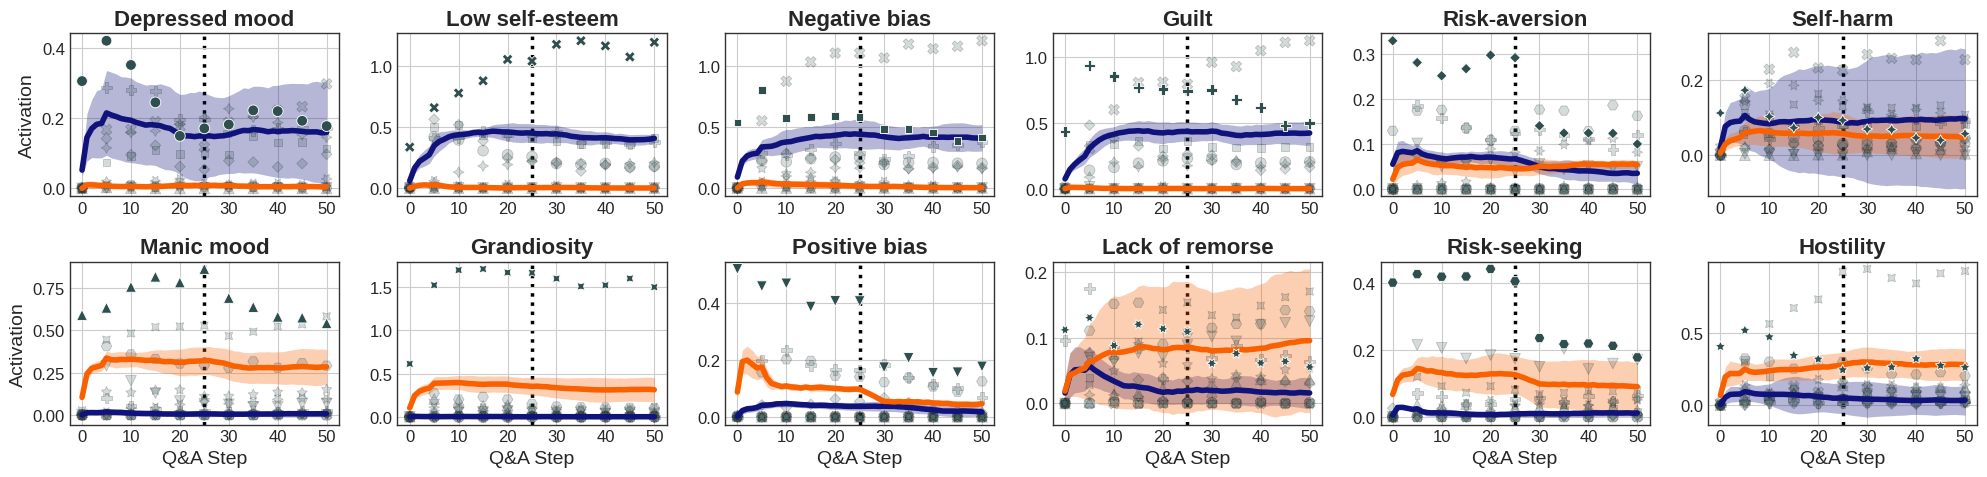

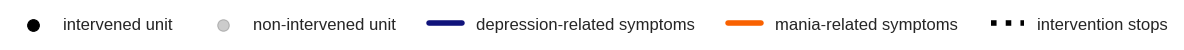

<Figure size 640x480 with 0 Axes>

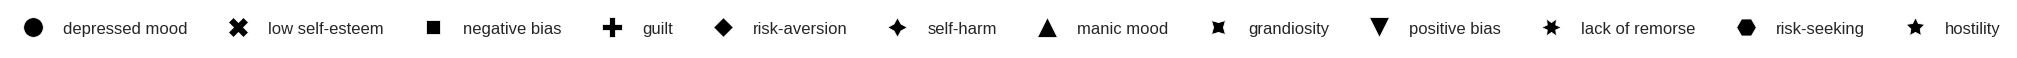

In [3]:
### Run this code only after obtaining:
### 1) activation_spread_eval - QNA/run_exp.ipynb

# --- 1. Load & Config ---
llm = "Qwen/Qwen3-32B"
save_result = False

print(f"Processing model: {llm}")
cfg = Config(model_id=llm)
dm = Data_Manager(cfg)

# Load existing results
res_path = f'{cfg.outcome_dir}/result_summary.json'
with open(res_path, 'r') as f: result = json.load(f)

# Load and Process Observational Data
out_df = dm.load_output(data_type='activation_spread_eval')
obs, itvn, obs_itv = df2obs(
    out_df, itv_type=['phase_3', 'phase_4'], itv_thought=symp_keys,
    sample_id=range(1, 11), step=range(0, 100), unit=symp_keys,
    dim_qkey_dict=dim_qkey_dict, abbv_dict=abbv_dict
)

# --- 2. Analysis & Plotting ---
fig, axes = plt.subplots(2, 6, figsize=(20, 5))
score_metrics = []

for ax, itv in zip(axes.flatten(), symp_keys):
    # Filter Data
    _obs_itv = obs[obs.index.get_level_values('itv_thought') == itv]
    if len(_obs_itv) < 2: continue

    # 1. Prepare Scatter Data (Vectorized "melt" instead of loops)
    # Average across samples per step, then melt to long format
    df_t = _obs_itv.groupby('step')[symp_keys].mean().reset_index().melt(
        id_vars='step', var_name='thought', value_name='score'
    )
    df_t['itv'] = df_t['thought'] == itv
    
    # 2. Calculate Metrics (Spread @ 25, Sustenance @ 50)
    score_metrics.append({
        'itv': itv,
        'spread': df_t.loc[df_t['step'] == 25, 'score'].mean(),
        'sustenance': df_t.loc[df_t['step'] == 50, 'score'].mean()
    })

    # 3. Prepare Trend Lines (Depressive vs Manic)
    # Identify column subsets
    d_cols = [c for c in obs.columns if c in depress_keys]
    m_cols = [c for c in obs.columns if c in manic_keys]
    
    d_trend = get_trend(_obs_itv, d_cols)
    m_trend = get_trend(_obs_itv, m_cols)

    # 4. Plotting
    # Downsample scatter for visual clarity
    df_scatter = df_t[(df_t['step'] == 50) | (df_t['step'] % 5 == 0)].copy()
    
    
    # Line Styles
    line_kws = dict(x='step', y='score', ax=ax, legend=False, zorder=2)
    sns.lineplot(data=d_trend, color=c_navy_rgb, errorbar='sd', linewidth=4, err_kws={'alpha': 0.3, 'linewidth': 0}, **line_kws)
    sns.lineplot(data=m_trend, color=c_darkorange_rgb, errorbar='sd', linewidth=4, err_kws={'alpha': 0.3, 'linewidth': 0}, **line_kws)

    # Scatter Styles 


    scat_kws = dict(x='step', y='score', ax=ax, style='thought', style_order=symp_keys, markers=True, legend=False)
    # Non-intervention thoughts (faded)
    sns.scatterplot(data=df_scatter[~df_scatter['itv']], color='darkslategray', alpha=0.2, s=60, edgecolor='black', linewidth=0.6, zorder=1, **scat_kws)
    # Intervention thought (bold)
    sns.scatterplot(data=df_scatter[df_scatter['itv']], color='darkslategray', alpha=1.0, s=60, zorder=3, **scat_kws)

    # Formatting
    ax.set_title(itv.capitalize(), fontweight='bold')
    ax.set_xlabel('Q&A Step' if ax in axes[-1, :] else '')
    ax.set_ylabel('Activation' if ax in axes[:, 0] else '')
    ax.set_xticks(np.arange(0, df_t['step'].max() + 1, 10))
    if df_t['step'].max() > 25:
        ax.axvline(x=25, color='black', linestyle='dotted', linewidth=2.5, zorder=0)

plt.tight_layout()

# --- 3. Save & Output ---
score_df = pd.DataFrame(score_metrics)
result['dynamics'] = {
    'spread': score_df['spread'].mean(),
    'sustenance': score_df['sustenance'].mean()
}

print(f"Avg Spread: {result['dynamics']['spread']:.4f}")
print(f"Avg Sustenance: {result['dynamics']['sustenance']:.4f}\n")

if save_result:
    plt.savefig(f'figures/dynamics_{cfg.model_id.split("/")[-1]}.svg', format='svg', bbox_inches='tight')
    with open(res_path, 'w') as f:
        json.dump(result, f, indent=4)

plt.show()


# --- 5. Legends ---
fig, ax = plt.subplots(figsize=(8, 0.4))
line1, = ax.plot([], [], color=c_navy_rgb, label='depression-related symptoms', linewidth=4)
line2, = ax.plot([], [], color=c_darkorange_rgb, label='mania-related symptoms', linewidth=4)
vline, = ax.plot([], [], color='black', label='intervention stops', linewidth=4, linestyle='dotted')
bluedot = ax.scatter([], [], color='black', label='intervened unit', s=70)
graydot = ax.scatter([], [], color='black', label='non-intervened unit', s=70, alpha=0.2)

ax.legend(handles=[bluedot, graydot, line1, line2, vline], loc='center', ncol=5, fontsize=12, bbox_to_anchor=(0.5, 0.5), frameon=False)
plt.axis('off') 
plt.show()

scatter = sns.scatterplot(data=df_t, x='step', y='score', ax=None, style="thought", markers=True, s=50, alpha=1, legend=True, palette=['black'], style_order=symp_keys, zorder=2, color='black')
handles, labels = scatter.get_legend_handles_labels()
scatter.remove()
fig_legend = plt.figure(figsize=(5, 0.5))  # Adjust figsize as needed
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, symp_keys, loc='center', ncol=12, fontsize=12, markerscale=2, frameon=False)
ax_legend.axis('off')
plt.tight_layout()
plt.show()

Processing model: Qwen/Qwen3-32B


Mean absolute lagged corr: 0.4315
Mean absolute lagged pcorr: 0.1151



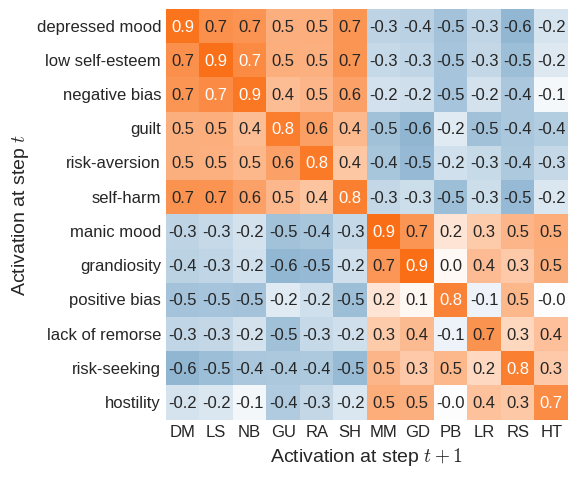

In [4]:
### Run this code only after obtaining:
### 1) activation_spread_eval - QNA/run_exp.ipynb

# --- 1. Load & Config ---
llm = "Qwen/Qwen3-32B"
save_result = False

print(f"Processing model: {llm}")
cfg = Config(model_id=llm)
dm = Data_Manager(cfg)

with open(f'{cfg.outcome_dir}/result_summary.json', 'r') as f:
    result = json.load(f)

# Load Observational Data
out_df = dm.load_output(data_type='activation_spread_eval')
obs, _, obs_itv = df2obs(
    out_df, itv_type=['phase_3', 'phase_4'], itv_thought=symp_keys,
    sample_id=range(1, 11), step=range(1, 100), unit=symp_keys,
    dim_qkey_dict=dim_qkey_dict, abbv_dict=abbv_dict
)

# --- 2. Vectorized Lag Generation ---
# Filter valid phases and thoughts
mask_thought = obs_itv.index.get_level_values('itv_thought').isin(symp_keys + ['none'])
mask_type = obs_itv.index.get_level_values('itv_type').isin(['phase_1', 'phase_3', 'phase_4'])
df_clean = obs_itv[mask_thought & mask_type][symp_keys].copy()

# Create t+1 (Target) vs t (Source) dataset
lag = 1
# Group by sample and intervention to prevent shifting data between unrelated trajectories
grouped = df_clean.groupby(['sample_id', 'itv_thought'])

# t (Source)
df_t = df_clean.copy() 
# t+1 (Target)
df_t_plus_1 = grouped.shift(-lag).add_suffix('_next')

# Combine and drop NaNs created by the shift
df_lagged = pd.concat([df_t, df_t_plus_1], axis=1).dropna()

# --- 3. Correlation Matrix Calculation ---
# Initialize matrices
lagged_corr_s = pd.DataFrame(index=symp_keys, columns=symp_keys, dtype=float)
lagged_pcorr_s = pd.DataFrame(index=symp_keys, columns=symp_keys, dtype=float)

for target, source in itertools.product(symp_keys, symp_keys):
    y_col = f"{target}_next"
    x_col = source
    
    # 1. Kendall Correlation (t vs t+1)
    tau, _ = statsc.kendalltau(df_lagged[x_col], df_lagged[y_col])
    lagged_corr_s.loc[target, source] = tau
    
    # 2. Partial Correlation (Spearman)
    # Control for all variables at time t (excluding the source predictor x)
    # This isolates the unique contribution of x_t to y_{t+1}
    covars = [k for k in symp_keys if k != source]
    stats = partial_corr(data=df_lagged, x=x_col, y=y_col, covar=covars, method='spearman')
    lagged_pcorr_s.loc[target, source] = stats['r'].values[0]

# --- 4. Plotting & Saving ---
# Update Results
avg_corr = np.mean(np.abs(lagged_corr_s.values))
avg_pcorr = np.mean(np.abs(lagged_pcorr_s.values))

result['dynamics'].update({
    'corr': avg_corr,
    'pcorr': avg_pcorr
})

print(f"Mean absolute lagged corr: {avg_corr:.4f}")
print(f"Mean absolute lagged pcorr: {avg_pcorr:.4f}\n")

fig, ax = plt.subplots(figsize=(6, 5))

# Plot Partial Correlation Heatmap (More informative for causal structure)
labels = [abbv_dict.get(k, k) for k in symp_keys]
sns.heatmap(
    lagged_corr_s.astype(float), cmap=diverging_cmap, fmt=".1f", vmin=-1, vmax=1,
    annot=True, annot_kws={"size": 12}, cbar=False, 
    xticklabels=labels, yticklabels=labels, ax=ax
)
xticks = ['DM', 'LS', 'NB', 'GU', 'RA', 'SH', 'MM', 'GD', 'PB', 'LR', 'RS', 'HT']
ax.set_title('')
ax.set_xlabel('Activation at step $t+1$')
ax.set_ylabel('Activation at step $t$')
plt.xticks(ticks=np.arange(0.5, 12.5), labels=xticks, rotation=0, ha='center');
plt.tight_layout()

if save_result:
    plt.savefig(f'figures/lagged_corr_{cfg.model_id.split("/")[-1]}.svg', format='svg', bbox_inches='tight')
    with open(f'{cfg.outcome_dir}/result_summary.json', 'w') as f:
        json.dump(result, f, indent=4)

plt.show()

Processing: Qwen/Qwen3-32B

--- Starting AIE Calculation (30 trials) ---
AIE Trial 1/30...
AIE Trial 2/30...
AIE Trial 3/30...
AIE Trial 4/30...
AIE Trial 5/30...
AIE Trial 6/30...
AIE Trial 7/30...
AIE Trial 8/30...
AIE Trial 9/30...
AIE Trial 10/30...
AIE Trial 11/30...
AIE Trial 12/30...
AIE Trial 13/30...
AIE Trial 14/30...
AIE Trial 15/30...
AIE Trial 16/30...
AIE Trial 17/30...
AIE Trial 18/30...
AIE Trial 19/30...
AIE Trial 20/30...
AIE Trial 21/30...
AIE Trial 22/30...
AIE Trial 23/30...
AIE Trial 24/30...
AIE Trial 25/30...
AIE Trial 26/30...
AIE Trial 27/30...
AIE Trial 28/30...
AIE Trial 29/30...
AIE Trial 30/30...


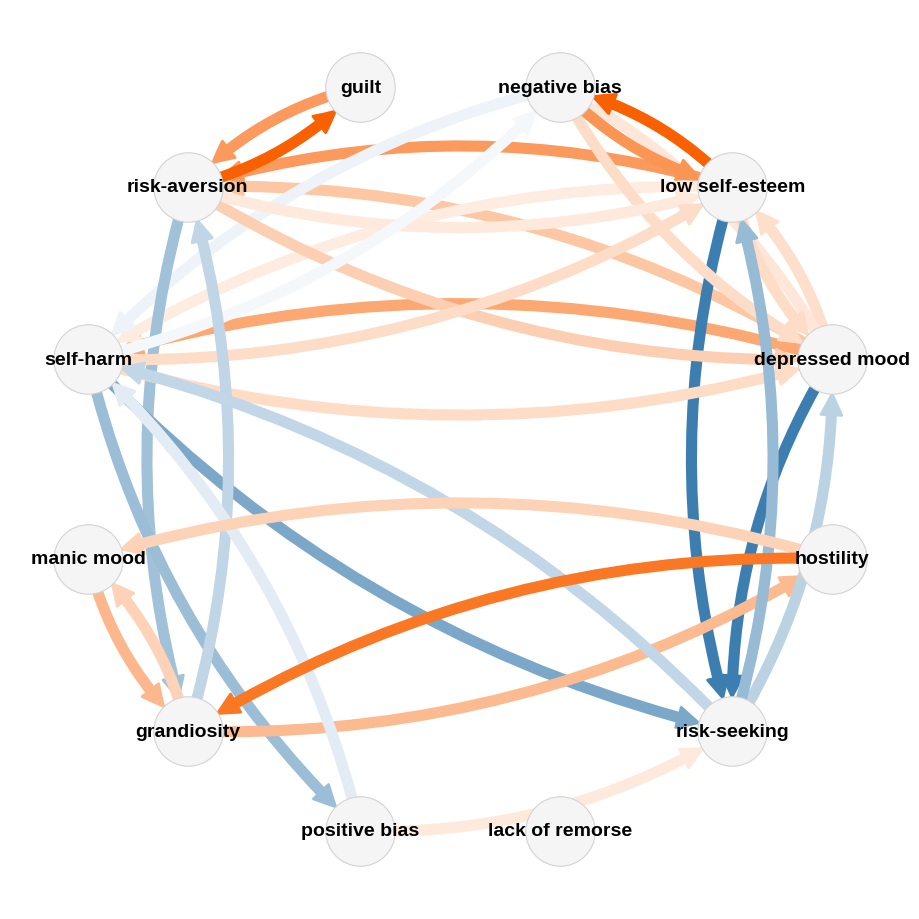

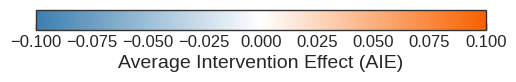

Fitting models for test fold: 1...
Fitting models for test fold: 2...
Fitting models for test fold: 3...
Fitting models for test fold: 4...
Fitting models for test fold: 5...

--- Final Cross-Validation Performance (R²) ---
+-----------+----------------+-------------+-------+-----------+-----------------+-----------------+------------+---------------+---------------+---------------+--------------+-----------+
|           | depressed mood | grandiosity | guilt | hostility | lack of remorse | low self-esteem | manic mood | negative bias | positive bias | risk-aversion | risk-seeking | self-harm |
+-----------+----------------+-------------+-------+-----------+-----------------+-----------------+------------+---------------+---------------+---------------+--------------+-----------+
|    r2     |      0.81      |    0.97     | 0.84  |   0.83    |      0.66       |      0.95       |    0.93    |     0.92      |     0.82      |     0.84      |     0.8      |   0.82    |
| mse_error |      0

In [ ]:
### Run this code only after obtaining:
### 1) activation_spread_eval - QNA/run_exp.ipynb
### 2) Causal Discovery results - causal_inference/main_causal_inf.py


# --- 1. Setup & Causal Discovery ---
draw_weight_graph = True
eval_scm = True
save_results = False
threshold = 0.7
full_vars = symp_keys + [c + '_itv' for c in symp_keys]


llm = "Qwen/Qwen3-32B"
print(f'Processing: {llm}')
cfg = Config(llm)
dm = Data_Manager(cfg)


# Load Causal Results
with open(f'{cfg.causal_inf_dir}/causal_inf_result_v4.1.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract DAGs and Bootstrap
dags = [
    r[1]._get_dag_from_cpdag(cpdag_graph=r[0]['graph'], variable_order=range(len(r[2].var_names))) 
    for r in results
]
adj_cat, adj_lag0, adj_lag1 = bootstrap_outcomes(
    dags, link_removal_threshold=int(len(dags) * threshold), num_full_vars=len(full_vars)
)
G, G0, G1 = get_nx_graphs(adj_cat, adj_lag0, adj_lag1, symp_keys)

# --- 2. SEM Modeling & AIE (Required for Drawing or Eval) ---
aie_df = None
if draw_weight_graph or eval_scm:
    # Load Observation Data
    out_df = dm.load_output(data_type='activation_spread_eval')
    obs, _, obs_itv = df2obs(
        out_df, itv_type=['phase_3', 'phase_4'], itv_thought=symp_keys,
        sample_id=range(1, 11), step=range(1, 100), unit=symp_keys,
        dim_qkey_dict=dim_qkey_dict, abbv_dict=abbv_dict
    )

    # Train SEM
    sem = StructuralEquationModeler(
        model_name='mlp', adj_lag0=adj_lag0, adj_lag1=adj_lag1,
        sys_vars=symp_keys, full_vars=full_vars, symp_label_dict=symp_label_dict
    )
    
    # Compute AIE
    aie_df = sem.compute_aie(
        data_list=sem._get_list_of_data(obs_itv), n_trials=30,
        n_context=int(6000 - 10 * len(symp_keys)),
        q_low=0.0, q_high=1.0, q_len=0.1
    )

# --- 3. Draw Graph ---
if draw_weight_graph:
    draw_graph(G1, symp_keys, diverging_cmap, aie_df, save_results)
else:
    draw_graph(G1, symp_keys, diverging_cmap)
    
# --- 4. Evaluation ---
if eval_scm and aie_df is not None:
    # Construct Positive Weight Graph
    G_positive_w = nx.DiGraph()
    G_positive_w.add_nodes_from(range(len(symp_keys)))
    
    # Create fast lookup for weights: (parent, child) -> weight
    w_map = dict(zip(zip(aie_df['parent'], aie_df['child']), aie_df['w_signed']))
    
    # Add only positive weighted edges
    pos_edges = []
    for u, v in G1.edges:
        w = w_map.get((symp_keys[u], symp_keys[v]), 0)
        if w > 0:
            pos_edges.append((u, v, {'weight': w}))
    G_positive_w.add_edges_from(pos_edges)

    # Metrics
    # Density (excluding self-loops)
    n_nodes = len(symp_keys)
    n_edges = len([(u, v) for u, v in G1.edges if u != v])
    density = n_edges / (n_nodes * (n_nodes - 1))
    
    # Prediction Score
    perf_df = sem.cross_validate(obs_itv)
    
    # Community Detection & ARI
    df_stat = graph_stats(G_positive_w, symp_keys, print_output=True)

    # used three different ground-truth community assignments to account for ambiguity
    # specifically, lack of remorse and hostility are pronounced symptoms in borderline personality disorder (group 2),
    # which can overlap with mania (group 1)
    gt_comms = [
        [0,0,0,0,0,0,1,1,1,1,1,1],
        [0,0,0,0,0,0,1,1,1,2,1,2],
        [0,0,0,0,0,0,1,1,1,2,2,2]
    ]
    ari = max(adjusted_rand_score(df_stat['comm_lv'], gt) for gt in gt_comms)
    
    pos_cycles = list(nx.simple_cycles(G_positive_w))
    
    print(f'Density: {density:.3f}, ARI: {ari:.3f}\n')

    # --- 5. Save Results ---
    if save_results:
        f_path = f'{cfg.outcome_dir}/result_summary.json'
        with open(f_path, 'r') as f: result_summary = json.load(f)
        
        result_summary.update({
            'density': density,
            'ari': ari,
            'num_cycle': len(pos_cycles)
        })
        
        with open(f_path, 'w') as f: json.dump(result_summary, f, indent=4)